# MVP: Engenharia de Dados
# 
**Autor:** Ana Clara de Almeida Marques

**Data:** 20/12/2025

**Matrícula:** 4052025001106

## Objetivo do MVP (problema e perguntas de análise)


Este MVP tem como objetivo construir, em ambiente de nuvem (Databricks Free), um pipeline de dados com camadas (staging → bronze → silver → gold) e um catálogo de dados, utilizando observações meteorológicas associadas a estações automáticas do Instituto Nacional de Meteorologia (INMET).

A motivação do problema é avaliar **confiabilidade** e **consistência** de um conjunto de dados meteorológicos e verificar se é possível extrair indicadores simples e interpretáveis para apoiar análises climáticas e de qualidade de dados.

Para viabilizar a execução no ambiente gratuito e manter o processamento em tempo adequado, foi realizado um recorte operacional do conjunto de dados, mantendo apenas as estações localizadas nas capitais dos estados do Brasil e restringindo o período para 2020 a 2024. Esse recorte foi adotado para reduzir volume de dados e custo computacional, preservando representatividade geográfica para as análises propostas.

### Situação investigada

O conjunto de dados meteorológicos é utilizado como base para análises. Antes de responder perguntas meteorológicas, é necessário avaliar completude, consistência e presença de valores suspeitos (outliers), além de entender como esses problemas variam entre estações e ao longo do tempo.

### Perguntas que este MVP busca responder

1. Quais estações apresentam mais falhas nos dados de precipitação (dados faltantes) ao longo do tempo?
2. Quais variáveis mais aparecem associadas a falhas no registro de precipitação (ex.: quando precipitação está ausente, quais outras variáveis também tendem a estar ausentes)?
3. Há padrões temporais (sazonais) nos faltantes de precipitação?
4. É possível identificar automaticamente outliers de precipitação com regras estatísticas (por exemplo, IQR por estação)?
5. Quais são os maiores eventos de precipitação diária no período e onde ocorreram?
6. Como é o comportamento sazonal médio (mensal) de precipitação e temperatura para DF e RJ no período 2020–2024?

### Observações sobre escopo

- Os dados trabalhados neste MVP estão na granularidade diária.
- A camada Gold foi utilizada para análises após tipagem e validações na camada Silver e enriquecimento com metadados das estações.

## Passo 0 — Preparação do ambiente (Catálogo + Schemas)

Nesta etapa é feito o preparo da estrutura do projeto no Databricks, criando um catálogo chamado mvp e quatro schemas que representam as camadas do pipeline:

- **staging**: área de aterrissagem dos arquivos coletados (CSVs baixados do GitHub)
- **bronze**: dados crus (ingestão com mínima transformação)
- **silver**: dados tratados (tipagem, limpeza e validações de qualidade)
- **gold**: dados prontos para consumo analítico (curados e/ou agregados)

Neste MVP serão coletados dois arquivos:

- inmet_capitais_2020_2024.csv (observações diárias)
- estacoes.csv (metadados das estações: região, UF, cidade, lat/lon, altitude, período de registro)

In [0]:
%sql
-- Passo 0: reset do ambiente do MVP (cuidado: apaga tudo do catálogo mvp)
DROP CATALOG IF EXISTS mvp CASCADE;

-- Cria e seleciona o catálogo do projeto
CREATE CATALOG mvp;
USE CATALOG mvp;

-- (Re)cria os schemas por camada
DROP SCHEMA IF EXISTS staging CASCADE;
CREATE SCHEMA staging;

DROP SCHEMA IF EXISTS bronze CASCADE;
CREATE SCHEMA bronze;

DROP SCHEMA IF EXISTS silver CASCADE;
CREATE SCHEMA silver;

DROP SCHEMA IF EXISTS gold CASCADE;
CREATE SCHEMA gold;


## Passo 1 — Coleta (download dos CSVs do GitHub para o staging)

Nesta etapa é realizada a coleta dos dados utilizados no MVP. Os arquivos CSV estão armazenados em um repositório público no GitHub e são acessados via link “raw”. Após o download, os arquivos são salvos em um **Volume** no schema **staging**, que funciona como área de aterrissagem (landing zone) do pipeline.

- **Origem**: GitHub (arquivos públicos)
- **Destino (Databricks Volume)**: `dbfs:/Volumes/mvp/staging/inmet/`
- **Arquivos coletados**:
  - `inmet_capitais_2020_2024.csv` — observações meteorológicas diárias (capitais, 2020–2024)
  - `estacoes.csv` — cadastro/metadados das estações (região, UF, cidade, coordenadas, altitude e período de registros)

In [0]:
# Passo 1: Coleta - baixar os CSVs do GitHub e salvar no Volume (staging)

spark.sql("USE CATALOG mvp")
spark.sql("USE SCHEMA staging")

spark.sql("CREATE VOLUME IF NOT EXISTS inmet")

# Fontes (GitHub raw)
URL_OBS = "https://raw.githubusercontent.com/ana-clara-marques/CD_PUCRIO_02/refs/heads/main/inmet_capitais_2020_2024.csv"
URL_EST = "https://raw.githubusercontent.com/ana-clara-marques/CD_PUCRIO_02/refs/heads/main/estacoes.csv"

# Destinos no Volume
PATH_OBS = "dbfs:/Volumes/mvp/staging/inmet/inmet_capitais_2020_2024.csv"
PATH_EST = "dbfs:/Volumes/mvp/staging/inmet/estacoes.csv"

dbutils.fs.cp(URL_OBS, PATH_OBS)
dbutils.fs.cp(URL_EST, PATH_EST)

display(dbutils.fs.ls("dbfs:/Volumes/mvp/staging/inmet/"))
print("✅ Coleta concluída (staging).")


path,name,size,modificationTime
dbfs:/Volumes/mvp/staging/inmet/estacoes.csv,estacoes.csv,47824,1766257258000
dbfs:/Volumes/mvp/staging/inmet/inmet_capitais_2020_2024.csv,inmet_capitais_2020_2024.csv,3241607,1766257257000


✅ Coleta concluída (staging).


## Passo 2 — Bronze (ingestão dos CSVs como tabelas Delta “cruas”)

Nesta etapa é feita a ingestão (Bronze) dos arquivos CSV armazenados no staging para tabelas Delta no schema bronze, mantendo os dados o mais próximo possível do formato original (sem limpeza pesada).

Também são adicionadas colunas de linhagem (fonte e timestamp de ingestão) e são registrados comentários de tabela e de colunas no catálogo, como parte da documentação do MVP.

In [0]:
# Passo 2: Bronze - ler CSVs do staging e persistir como Delta (bronze)

import re
from pyspark.sql.functions import current_timestamp, lit

spark.sql("USE CATALOG mvp")
spark.sql("USE SCHEMA bronze")

# Usa os caminhos definidos no Passo 1 (PATH_OBS, PATH_EST)
path_obs = PATH_OBS
path_est = PATH_EST

# Linhagem (curta e estável): referência ao repositório/dataset do MVP
source_ref = "GitHub repo: ana-clara-marques/CD_PUCRIO_02 (arquivos raw)"

def normalize_col(name: str) -> str:
    name = name.strip().lower()
    name = re.sub(r"[^0-9a-z]+", "_", name)
    name = re.sub(r"_+", "_", name).strip("_")
    return name

# --- Observações ---
df_obs = (
    spark.read.option("header", True)
    .option("sep", ",")
    .option("quote", '"')
    .option("inferSchema", False)
    .csv(path_obs)
)

# padroniza colunas
rename_map = {}
for c in df_obs.columns:
    nc = normalize_col(c)
    if nc in ["estacao", "id_estacao"]:
        nc = "id_station"
    if nc.startswith("data"):
        nc = "date"
    rename_map[c] = nc

for old, new in rename_map.items():
    df_obs = df_obs.withColumnRenamed(old, new)

df_obs = (
    df_obs.withColumn("_ingestion_ts", current_timestamp())
          .withColumn("_source_ref", lit(source_ref))
)

# --- Estações ---
df_est = (
    spark.read.option("header", True)
    .option("sep", ",")
    .option("quote", '"')
    .option("inferSchema", False)
    .csv(path_est)
)

for c in df_est.columns:
    df_est = df_est.withColumnRenamed(c, normalize_col(c))

df_est = (
    df_est.withColumn("_ingestion_ts", current_timestamp())
          .withColumn("_source_ref", lit(source_ref))
)

# Persistência
df_obs.write.format("delta").mode("overwrite").saveAsTable("observacoes_raw")
df_est.write.format("delta").mode("overwrite").saveAsTable("estacoes_raw")

spark.sql("""
  COMMENT ON TABLE mvp.bronze.observacoes_raw IS
  'Camada Bronze (raw): observações meteorológicas diárias (capitais, 2020–2024) ingeridas do staging. Colunas padronizadas para compatibilidade com Delta. Inclui linhagem (_source_ref, _ingestion_ts).'
""")

spark.sql("""
  COMMENT ON TABLE mvp.bronze.estacoes_raw IS
  'Camada Bronze (raw): cadastro/metadados das estações ingeridos do staging. Inclui linhagem (_source_ref, _ingestion_ts).'
""")

print("✅ Bronze concluído: mvp.bronze.observacoes_raw e mvp.bronze.estacoes_raw")


✅ Bronze concluído: mvp.bronze.observacoes_raw e mvp.bronze.estacoes_raw


## Passo 3 — Silver (tipagem, conversões e validações de qualidade)

Nesta etapa os dados da camada Bronze são transformados para a camada Silver, com foco em:

- Tipagem correta (date como data; variáveis meteorológicas como numéricas)
- Conversão segura de valores numéricos usando try_cast (valores malformados como 'F' passam a NULL sem quebrar o pipeline)
- Conversão de decimais com vírgula (',' → '.') na tabela de estações e nas variáveis meteorológicas
- Regras básicas de qualidade (ex.: chuva ≥ 0, radiação ≥ 0, umidade entre 0 e 100, temp_min ≤ temp_max)
- Criação de duas saídas:
- Materialização das saídas:
- - mvp.silver.estacoes_clean
- - mvp.silver.observacoes_clean
- - mvp.silver.observacoes_invalid (linhas com violações de qualidade)

Também é verificada a integridade entre observações e cadastro de estações (se existe id_station nas observações que não aparece em estacoes_clean).

In [0]:
# Passo 3: Silver - tipagem, conversões seguras (try_cast) e validações de qualidade

from pyspark.sql.functions import (
    col, trim, upper, to_date, regexp_replace, when, lit, concat_ws, expr
)

spark.sql("USE CATALOG mvp")
spark.sql("USE SCHEMA silver")

# =========================
# 1) ESTAÇÕES -> estacoes_clean
# =========================
est = spark.table("mvp.bronze.estacoes_raw")

# padroniza id_station
if "id_station" in est.columns:
    est = est.withColumn("id_station", upper(trim(col("id_station"))))

# conversão segura de numéricos com vírgula -> ponto
for num_col in ["lat", "lon", "lvl"]:
    if num_col in est.columns:
        est = est.withColumn(
            num_col,
            expr(f"try_cast(regexp_replace(trim(cast(`{num_col}` as string)), ',', '.') as double)")
        )

# datas
for dt_col in ["record_first", "record_last"]:
    if dt_col in est.columns:
        est = est.withColumn(dt_col, to_date(col(dt_col), "yyyy-MM-dd"))

est.write.format("delta").mode("overwrite").saveAsTable("estacoes_clean")


# =========================
# 2) OBSERVAÇÕES -> conversão/validação
# =========================
obs0 = spark.table("mvp.bronze.observacoes_raw")

# chaves e data
obs = obs0
if "id_station" in obs.columns:
    obs = obs.withColumn("id_station", upper(trim(col("id_station"))))

if "date" in obs.columns:
    obs = obs.withColumn("date", to_date(col("date"), "yyyy-MM-dd"))

# converte todas as demais colunas para double de forma segura (try_cast)
skip_cols = {"id_station", "date", "_ingestion_ts", "_source_url"}

# guarda expressões de erro de parse (para auditoria)
parse_checks = []

for c in obs.columns:
    if c in skip_cols:
        continue

    original = trim(col(c).cast("string"))
    parsed = expr(f"try_cast(regexp_replace(trim(cast(`{c}` as string)), ',', '.') as double)")

    # marca erro quando havia valor preenchido mas não foi possível converter
    parse_checks.append((
        f"parse_error_{c}",
        original.isNotNull() & (original != "") & parsed.isNull()
    ))

    obs = obs.withColumn(c, parsed)


# =========================
# 3) Regras de qualidade (por nomes de colunas)
# =========================
dq_checks = []

# chuva: colunas com "rain" -> >= 0
for c in obs.columns:
    if "rain" in c:
        dq_checks.append((f"{c}_negativa", col(c).isNotNull() & (col(c) < 0)))

# radiação: colunas com "rad" -> >= 0
for c in obs.columns:
    if "rad" in c:
        dq_checks.append((f"{c}_negativa", col(c).isNotNull() & (col(c) < 0)))

# umidade: colunas com "hum" -> 0..100
for c in obs.columns:
    if "hum" in c:
        dq_checks.append((f"{c}_fora_0_100", col(c).isNotNull() & ((col(c) < 0) | (col(c) > 100))))

# consistência temperatura: temp_min <= temp_max (se existirem)
if "temp_min" in obs.columns and "temp_max" in obs.columns:
    dq_checks.append((
        "temp_min_maior_temp_max",
        col("temp_min").isNotNull() & col("temp_max").isNotNull() & (col("temp_min") > col("temp_max"))
    ))

# junta parse_checks + dq_checks em dq_errors
all_checks = parse_checks + dq_checks
error_exprs = [when(cond, lit(name)) for name, cond in all_checks]
obs_checked = obs.withColumn("dq_errors", concat_ws("|", *error_exprs))

# separa válidos e inválidos
obs_valid = obs_checked.filter((col("dq_errors").isNull()) | (col("dq_errors") == ""))
obs_invalid = obs_checked.filter((col("dq_errors").isNotNull()) & (col("dq_errors") != ""))

obs_valid.write.format("delta").mode("overwrite").saveAsTable("observacoes_clean")
obs_invalid.write.format("delta").mode("overwrite").saveAsTable("observacoes_invalid")


# =========================
# 4) Checagens rápidas
# =========================
print("Contagens (Silver):")
print(" - observacoes_clean:", spark.table("mvp.silver.observacoes_clean").count())
print(" - observacoes_invalid:", spark.table("mvp.silver.observacoes_invalid").count())
print(" - estacoes_clean:", spark.table("mvp.silver.estacoes_clean").count())

# integridade: estações em observações sem correspondência no cadastro
obs_ids = spark.table("mvp.silver.observacoes_clean").select("id_station").distinct()
est_ids = spark.table("mvp.silver.estacoes_clean").select("id_station").distinct()
sem_dim = obs_ids.join(est_ids, on="id_station", how="left_anti").count()
print(" - id_station em observações sem correspondência em estacoes_clean:", sem_dim)

print("\nPreview observacoes_clean:")
display(spark.table("mvp.silver.observacoes_clean").limit(10))

print("\nPreview estacoes_clean:")
display(spark.table("mvp.silver.estacoes_clean").limit(10))

print("\nPreview observacoes_invalid (se houver):")
display(spark.table("mvp.silver.observacoes_invalid").limit(10))


Contagens (Silver):
 - observacoes_clean: 47639
 - observacoes_invalid: 0
 - estacoes_clean: 615
 - id_station em observações sem correspondência em estacoes_clean: 0

Preview observacoes_clean:


id_station,date,rain_max,rad_max,temp_avg,temp_max,temp_min,hum_max,hum_min,wind_max,wind_avg,_ingestion_ts,_source_ref,dq_errors
A001,2020-01-01,0.2,2426.5,21.1625,25.2,18.7,94.0,56.0,8.9,1.5166667,2025-12-20T19:01:01.707Z,null,
A001,2020-01-02,0.0,2899.6,21.879168,27.1,19.1,92.0,54.0,8.0,2.7833333,2025-12-20T19:01:01.707Z,null,
A001,2020-01-03,15.0,2925.5,21.395834,27.6,18.3,95.0,55.0,10.8,2.625,2025-12-20T19:01:01.707Z,null,
A001,2020-01-04,6.0,2925.8,20.3,25.2,18.8,95.0,65.0,13.0,3.4375,2025-12-20T19:01:01.707Z,null,
A001,2020-01-05,10.6,1564.2,19.120832,23.0,17.4,96.0,79.0,9.0,2.1333334,2025-12-20T19:01:01.707Z,null,
A001,2020-01-06,0.6,2474.7,20.795834,25.6,18.3,95.0,63.0,12.9,3.7583334,2025-12-20T19:01:01.707Z,null,
A001,2020-01-07,0.0,3848.6,22.125,27.8,18.9,92.0,56.0,8.4,2.8875,2025-12-20T19:01:01.707Z,null,
A001,2020-01-08,1.6,2577.4,22.429167,27.3,19.4,95.0,54.0,6.4,1.7958333,2025-12-20T19:01:01.707Z,null,
A001,2020-01-09,5.6,3422.3,21.345833,27.2,18.1,95.0,59.0,12.6,1.5416666,2025-12-20T19:01:01.707Z,null,
A001,2020-01-10,0.2,3866.6,22.766666,29.9,17.8,96.0,43.0,7.0,1.925,2025-12-20T19:01:01.707Z,null,



Preview estacoes_clean:


region,state,city_station,id_station,lat,lon,lvl,record_first,record_last,_ingestion_ts,_source_ref
CO,DF,BRASILIA,A001,-15.78944444,-47.92583332,1159.54,2000-05-07,2025-07-31,2025-12-20T19:01:04.928Z,GitHub repo: ana-clara-marques/CD_PUCRIO_02 (arquivos raw)
NE,BA,SALVADOR,A401,-13.01666666,-38.51666666,51.41,2000-05-13,2025-07-31,2025-12-20T19:01:04.928Z,GitHub repo: ana-clara-marques/CD_PUCRIO_02 (arquivos raw)
N,AM,MANAUS,A101,-3.10333333,-60.01638888,61.25,2000-05-09,2025-07-31,2025-12-20T19:01:04.928Z,GitHub repo: ana-clara-marques/CD_PUCRIO_02 (arquivos raw)
SE,RJ,ECOLOGIA AGRICOLA,A601,-22.8,-43.68333333,33.0,2000-05-07,2025-07-31,2025-12-20T19:01:04.928Z,GitHub repo: ana-clara-marques/CD_PUCRIO_02 (arquivos raw)
S,RS,PORTO ALEGRE,A801,-30.05,-51.16666666,46.97,2000-09-22,2025-07-31,2025-12-20T19:01:04.928Z,GitHub repo: ana-clara-marques/CD_PUCRIO_02 (arquivos raw)
CO,GO,GOIANIA,A002,-16.64277777,-49.21999999,770.0,2001-05-29,2025-05-19,2025-12-20T19:01:04.928Z,GitHub repo: ana-clara-marques/CD_PUCRIO_02 (arquivos raw)
CO,GO,MORRINHOS,A003,-17.71666667,-49.1,771.42,2001-05-25,2025-07-31,2025-12-20T19:01:04.928Z,GitHub repo: ana-clara-marques/CD_PUCRIO_02 (arquivos raw)
CO,MS,CAMPO GRANDE,A702,-20.45,-54.6,530.0,2001-09-10,2025-07-31,2025-12-20T19:01:04.928Z,GitHub repo: ana-clara-marques/CD_PUCRIO_02 (arquivos raw)
CO,MS,PONTA PORA,A703,-22.5525,-55.71638888,675.0,2001-09-07,2025-07-31,2025-12-20T19:01:04.928Z,GitHub repo: ana-clara-marques/CD_PUCRIO_02 (arquivos raw)
CO,MS,TRES LAGOAS,A704,-20.78999999,-51.71222222,313.0,2001-09-03,2025-07-31,2025-12-20T19:01:04.928Z,GitHub repo: ana-clara-marques/CD_PUCRIO_02 (arquivos raw)



Preview observacoes_invalid (se houver):


id_station,date,rain_max,rad_max,temp_avg,temp_max,temp_min,hum_max,hum_min,wind_max,wind_avg,_ingestion_ts,_source_ref,dq_errors


## Passo 4 — Gold (tabelas prontas para análise + enriquecimento com metadados das estações)

Nesta etapa é construída a camada Gold, voltada para consumo analítico.
A tabela principal é criada a partir de observacoes_clean e enriquecida com estacoes_clean, incorporando atributos como região, UF, cidade e coordenadas.

Também são geradas tabelas agregadas para facilitar análises:
- por estação e ano
- por estação e mês

In [0]:
%sql
USE CATALOG mvp;
USE SCHEMA gold;

-- 1) Tabela Gold principal (flat), enriquecida com metadados das estações
CREATE OR REPLACE TABLE observacoes_gold AS
SELECT
  o.id_station,
  e.region,
  e.state,
  e.city_station,
  e.lat,
  e.lon,
  e.lvl,
  o.date,
  year(o.date)  AS year,
  month(o.date) AS month,
  o.rain_max,
  o.rad_max,
  o.temp_avg,
  o.temp_max,
  o.temp_min,
  o.hum_max,
  o.hum_min,
  o.wind_max,
  o.wind_avg
FROM mvp.silver.observacoes_clean o
LEFT JOIN mvp.silver.estacoes_clean e
  ON o.id_station = e.id_station;

-- 2) Agregação anual por estação (exemplos)
CREATE OR REPLACE TABLE agg_anual_estacao AS
SELECT
  id_station,
  region,
  state,
  city_station,
  year,
  COUNT(*)                   AS n_dias,
  SUM(rain_max)              AS chuva_total_ano,
  AVG(temp_avg)              AS temp_media_ano,
  MAX(temp_max)              AS temp_max_ano,
  MIN(temp_min)              AS temp_min_ano,
  AVG(wind_avg)              AS vento_medio_ano,
  MAX(wind_max)              AS vento_max_ano
FROM observacoes_gold
GROUP BY id_station, region, state, city_station, year;

-- 3) Agregação mensal por estação
CREATE OR REPLACE TABLE agg_mensal_estacao AS
SELECT
  id_station,
  region,
  state,
  city_station,
  year,
  month,
  COUNT(*)                   AS n_dias,
  SUM(rain_max)              AS chuva_total_mes,
  AVG(temp_avg)              AS temp_media_mes,
  MAX(temp_max)              AS temp_max_mes,
  MIN(temp_min)              AS temp_min_mes,
  AVG(hum_max)               AS umid_max_media_mes,
  AVG(hum_min)               AS umid_min_media_mes
FROM observacoes_gold
GROUP BY id_station, region, state, city_station, year, month;

-- Preview
SELECT * FROM observacoes_gold LIMIT 10;


id_station,region,state,city_station,lat,lon,lvl,date,year,month,rain_max,rad_max,temp_avg,temp_max,temp_min,hum_max,hum_min,wind_max,wind_avg
A001,CO,DF,BRASILIA,-15.78944444,-47.92583332,1159.54,2020-01-01,2020,1,0.2,2426.5,21.1625,25.2,18.7,94.0,56.0,8.9,1.5166667
A001,CO,DF,BRASILIA,-15.78944444,-47.92583332,1159.54,2020-01-02,2020,1,0.0,2899.6,21.879168,27.1,19.1,92.0,54.0,8.0,2.7833333
A001,CO,DF,BRASILIA,-15.78944444,-47.92583332,1159.54,2020-01-03,2020,1,15.0,2925.5,21.395834,27.6,18.3,95.0,55.0,10.8,2.625
A001,CO,DF,BRASILIA,-15.78944444,-47.92583332,1159.54,2020-01-04,2020,1,6.0,2925.8,20.3,25.2,18.8,95.0,65.0,13.0,3.4375
A001,CO,DF,BRASILIA,-15.78944444,-47.92583332,1159.54,2020-01-05,2020,1,10.6,1564.2,19.120832,23.0,17.4,96.0,79.0,9.0,2.1333334
A001,CO,DF,BRASILIA,-15.78944444,-47.92583332,1159.54,2020-01-06,2020,1,0.6,2474.7,20.795834,25.6,18.3,95.0,63.0,12.9,3.7583334
A001,CO,DF,BRASILIA,-15.78944444,-47.92583332,1159.54,2020-01-07,2020,1,0.0,3848.6,22.125,27.8,18.9,92.0,56.0,8.4,2.8875
A001,CO,DF,BRASILIA,-15.78944444,-47.92583332,1159.54,2020-01-08,2020,1,1.6,2577.4,22.429167,27.3,19.4,95.0,54.0,6.4,1.7958333
A001,CO,DF,BRASILIA,-15.78944444,-47.92583332,1159.54,2020-01-09,2020,1,5.6,3422.3,21.345833,27.2,18.1,95.0,59.0,12.6,1.5416666
A001,CO,DF,BRASILIA,-15.78944444,-47.92583332,1159.54,2020-01-10,2020,1,0.2,3866.6,22.766666,29.9,17.8,96.0,43.0,7.0,1.925



## Passo 5 — Análises (qualidade dos dados, falhas/inconsistências e outliers)

Nesta etapa são realizadas análises na camada Gold com dois focos:

- Qualidade dos dados: medir completude por estação e variável e verificar inconsistências físicas simples (ex.: temp_min > temp_max, umidade fora de 0–100)
- Investigação de falhas e outliers: tratar “erro” como problema de registro/medição (faltantes, inconsistências e valores extremos), avaliando:
- - estações com maior proporção de falhas ao longo do período;
- - relações entre faltantes de precipitação e faltantes de outras variáveis;
- - padrão temporal (mensal) de faltantes;
- - detecção automática de outliers de precipitação por estação (IQR).

In [0]:
%sql
USE CATALOG mvp;
USE SCHEMA gold;

-- =========================================================
-- 0) Visão geral do dataset
-- =========================================================
SELECT
  COUNT(*) AS n_registros,
  COUNT(DISTINCT id_station) AS n_estacoes,
  MIN(date) AS data_inicial,
  MAX(date) AS data_final
FROM observacoes_gold;

-- =========================================================
-- 1) Completude por estação (faltantes por variável)
-- =========================================================
SELECT
  id_station, city_station, state, region,
  COUNT(*) AS n_dias,
  ROUND(100.0 * SUM(CASE WHEN rain_max IS NULL THEN 1 ELSE 0 END) / COUNT(*), 2) AS pct_null_rain,
  ROUND(100.0 * SUM(CASE WHEN rad_max  IS NULL THEN 1 ELSE 0 END) / COUNT(*), 2) AS pct_null_rad,
  ROUND(100.0 * SUM(CASE WHEN temp_avg IS NULL THEN 1 ELSE 0 END) / COUNT(*), 2) AS pct_null_temp_avg,
  ROUND(100.0 * SUM(CASE WHEN temp_max IS NULL THEN 1 ELSE 0 END) / COUNT(*), 2) AS pct_null_temp_max,
  ROUND(100.0 * SUM(CASE WHEN temp_min IS NULL THEN 1 ELSE 0 END) / COUNT(*), 2) AS pct_null_temp_min,
  ROUND(100.0 * SUM(CASE WHEN hum_max  IS NULL THEN 1 ELSE 0 END) / COUNT(*), 2) AS pct_null_hum_max,
  ROUND(100.0 * SUM(CASE WHEN hum_min  IS NULL THEN 1 ELSE 0 END) / COUNT(*), 2) AS pct_null_hum_min,
  ROUND(100.0 * SUM(CASE WHEN wind_max IS NULL THEN 1 ELSE 0 END) / COUNT(*), 2) AS pct_null_wind_max,
  ROUND(100.0 * SUM(CASE WHEN wind_avg IS NULL THEN 1 ELSE 0 END) / COUNT(*), 2) AS pct_null_wind_avg
FROM observacoes_gold
GROUP BY id_station, city_station, state, region
ORDER BY pct_null_rain DESC, n_dias DESC;

-- =========================================================
-- 2) Inconsistências físicas simples (qualidade)
-- =========================================================
-- 2.1 temp_min > temp_max
SELECT COUNT(*) AS n_temp_inconsistente
FROM observacoes_gold
WHERE temp_min IS NOT NULL AND temp_max IS NOT NULL
  AND temp_min > temp_max;

-- 2.2 umidade fora de 0-100
SELECT COUNT(*) AS n_umidade_fora_0_100
FROM observacoes_gold
WHERE (hum_max IS NOT NULL AND (hum_max < 0 OR hum_max > 100))
   OR (hum_min IS NOT NULL AND (hum_min < 0 OR hum_min > 100));

-- 2.3 hum_min > hum_max
SELECT COUNT(*) AS n_umidade_inconsistente
FROM observacoes_gold
WHERE hum_min IS NOT NULL AND hum_max IS NOT NULL
  AND hum_min > hum_max;

-- 2.4 chuva negativa
SELECT COUNT(*) AS n_chuva_negativa
FROM observacoes_gold
WHERE rain_max IS NOT NULL AND rain_max < 0;

-- =========================================================
-- 3) Relação entre faltantes de precipitação e faltantes de outras variáveis
-- (proxy simples para investigar falhas de medição/registro)
-- =========================================================
SELECT
  id_station, city_station, state,
  COUNT(*) AS n_dias_total,
  SUM(CASE WHEN rain_max IS NULL THEN 1 ELSE 0 END) AS n_dias_sem_chuva,
  ROUND(100.0 * SUM(CASE WHEN rain_max IS NULL THEN 1 ELSE 0 END) / COUNT(*), 2) AS pct_dias_sem_chuva,
  ROUND(100.0 * AVG(CASE WHEN rain_max IS NULL AND rad_max  IS NULL THEN 1 ELSE 0 END), 2) AS pct_sem_chuva_e_sem_rad,
  ROUND(100.0 * AVG(CASE WHEN rain_max IS NULL AND temp_avg IS NULL THEN 1 ELSE 0 END), 2) AS pct_sem_chuva_e_sem_temp_avg,
  ROUND(100.0 * AVG(CASE WHEN rain_max IS NULL AND hum_max  IS NULL THEN 1 ELSE 0 END), 2) AS pct_sem_chuva_e_sem_hum_max,
  ROUND(100.0 * AVG(CASE WHEN rain_max IS NULL AND wind_avg IS NULL THEN 1 ELSE 0 END), 2) AS pct_sem_chuva_e_sem_vento
FROM observacoes_gold
GROUP BY id_station, city_station, state
ORDER BY pct_dias_sem_chuva DESC, n_dias_total DESC;

-- =========================================================
-- 4) Padrão temporal (mensal) de faltantes de precipitação
-- =========================================================
SELECT
  id_station, city_station, state,
  month,
  ROUND(100.0 * AVG(CASE WHEN rain_max IS NULL THEN 1 ELSE 0 END), 2) AS pct_dias_sem_chuva_no_mes
FROM observacoes_gold
GROUP BY id_station, city_station, state, month
ORDER BY id_station, month;

-- =========================================================
-- 5) Outliers automáticos de precipitação (IQR por estação)
-- =========================================================
WITH stats AS (
  SELECT
    id_station,
    percentile_approx(rain_max, 0.25) AS q1,
    percentile_approx(rain_max, 0.75) AS q3
  FROM observacoes_gold
  WHERE rain_max IS NOT NULL
  GROUP BY id_station
),
limites AS (
  SELECT
    id_station,
    q1, q3,
    (q3 - q1) AS iqr,
    (q3 + 1.5 * (q3 - q1)) AS lim_sup
  FROM stats
)
SELECT
  o.id_station, o.city_station, o.state, o.region,
  o.date, o.rain_max,
  l.q1, l.q3, l.lim_sup
FROM observacoes_gold o
JOIN limites l ON o.id_station = l.id_station
WHERE o.rain_max IS NOT NULL
  AND o.rain_max > l.lim_sup
ORDER BY o.rain_max DESC
LIMIT 50;

-- =========================================================
-- 6) Climatologia mensal por capital (2020–2024)
-- =========================================================
WITH mensal AS (
  SELECT
    id_station, city_station, state, region,
    year, month,
    SUM(rain_max) AS chuva_total_mes_mm,
    AVG(temp_avg) AS temp_media_mes
  FROM observacoes_gold
  WHERE rain_max IS NOT NULL OR temp_avg IS NOT NULL
  GROUP BY id_station, city_station, state, region, year, month
)
SELECT
  city_station, state, region, month,
  ROUND(AVG(chuva_total_mes_mm), 1) AS chuva_media_mensal_mm,
  ROUND(AVG(temp_media_mes), 1)     AS temp_media_mensal_c
FROM mensal
GROUP BY city_station, state, region, month
ORDER BY city_station, month;


city_station,state,region,month,chuva_media_mensal_mm,temp_media_mensal_c
ARACAJU,SE,NE,1,31.5,27.7
ARACAJU,SE,NE,2,53.3,28.4
ARACAJU,SE,NE,3,74.2,28.5
ARACAJU,SE,NE,4,103.5,27.8
ARACAJU,SE,NE,5,114.2,26.3
ARACAJU,SE,NE,6,86.5,25.6
ARACAJU,SE,NE,7,73.9,25.0
ARACAJU,SE,NE,8,41.5,25.2
ARACAJU,SE,NE,9,19.6,25.8
ARACAJU,SE,NE,10,21.7,26.6


## Análises finais — Respostas às perguntas do MVP (camada Gold)

Nesta seção são apresentadas consultas e visualizações para responder às perguntas do MVP:

1. Quais estações apresentam mais falhas nos dados de precipitação (dados faltantes) ao longo do tempo?
2. Quais variáveis aparecem mais associadas a falhas no registro de precipitação?
3. Há padrões temporais (mensais) nos faltantes de precipitação?
4. É possível identificar automaticamente outliers de precipitação (IQR por estação)?
5. Quais são os maiores eventos de precipitação diária no período e onde ocorreram?
6. Como é o comportamento sazonal médio (mensal) de precipitação e temperatura para DF e RJ (2020–2024)?


In [0]:
%sql
USE CATALOG mvp;
USE SCHEMA gold;

-- =========================================================
-- Q1) Quais estações apresentam mais falhas (faltantes) ao longo do tempo?
-- (Top 15 por % de dias com precipitação ausente = rain_max NULL)
-- =========================================================
SELECT
  CONCAT(city_station, ' (', state, ')') AS local,
  COUNT(*) AS n_dias,
  SUM(CASE WHEN rain_max IS NULL THEN 1 ELSE 0 END) AS n_dias_rain_null,
  ROUND(100.0 * SUM(CASE WHEN rain_max IS NULL THEN 1 ELSE 0 END) / COUNT(*), 2) AS pct_rain_null
FROM observacoes_gold
GROUP BY city_station, state
ORDER BY pct_rain_null DESC, n_dias_rain_null DESC
LIMIT 15;


-- =========================================================
-- Q2) Quais variáveis aparecem mais associadas a falhas no registro de precipitação?
-- (Quando rain_max é NULL, % que também está NULL em outras variáveis)
-- =========================================================
SELECT
  SUM(CASE WHEN rain_max IS NULL THEN 1 ELSE 0 END) AS n_dias_rain_null,
  ROUND(100.0 * AVG(CASE WHEN rain_max IS NULL AND rad_max  IS NULL THEN 1 ELSE 0 END), 2) AS pct_rain_null_com_rad_null,
  ROUND(100.0 * AVG(CASE WHEN rain_max IS NULL AND temp_avg IS NULL THEN 1 ELSE 0 END), 2) AS pct_rain_null_com_temp_null,
  ROUND(100.0 * AVG(CASE WHEN rain_max IS NULL AND hum_max  IS NULL THEN 1 ELSE 0 END), 2) AS pct_rain_null_com_hum_null,
  ROUND(100.0 * AVG(CASE WHEN rain_max IS NULL AND wind_avg IS NULL THEN 1 ELSE 0 END), 2) AS pct_rain_null_com_vento_null
FROM observacoes_gold;


-- =========================================================
-- Q3) Há padrões temporais (mensais) nos faltantes de precipitação?
-- (% de dias com rain_max NULL por mês)
-- =========================================================
SELECT
  month,
  COUNT(*) AS n_dias_total,
  SUM(CASE WHEN rain_max IS NULL THEN 1 ELSE 0 END) AS n_dias_rain_null,
  ROUND(100.0 * SUM(CASE WHEN rain_max IS NULL THEN 1 ELSE 0 END) / COUNT(*), 2) AS pct_rain_null
FROM observacoes_gold
GROUP BY month
ORDER BY month;


-- =========================================================
-- Q4) É possível identificar automaticamente outliers de precipitação (IQR por estação)?
-- (Top 20 maiores outliers: rain_max > Q3 + 1.5*IQR)
-- =========================================================
WITH stats AS (
  SELECT
    id_station,
    percentile_approx(rain_max, 0.25) AS q1,
    percentile_approx(rain_max, 0.75) AS q3
  FROM observacoes_gold
  WHERE rain_max IS NOT NULL
  GROUP BY id_station
),
lim AS (
  SELECT
    id_station,
    (q3 + 1.5 * (q3 - q1)) AS lim_sup
  FROM stats
)
SELECT
  date, city_station, state, id_station,
  rain_max AS chuva_dia_mm,
  ROUND(lim_sup, 2) AS lim_sup
FROM observacoes_gold o
JOIN lim l USING (id_station)
WHERE o.rain_max IS NOT NULL AND o.rain_max > l.lim_sup
ORDER BY chuva_dia_mm DESC
LIMIT 20;


-- =========================================================
-- Q5) Quais são os maiores eventos de precipitação diária no período e onde ocorreram?
-- (Top 20 por rain_max)
-- =========================================================
SELECT
  date,
  CONCAT(city_station, ' (', state, ')') AS local,
  id_station,
  rain_max AS chuva_dia_mm
FROM observacoes_gold
WHERE rain_max IS NOT NULL
ORDER BY chuva_dia_mm DESC
LIMIT 20;


-- =========================================================
-- Q6) Como é o comportamento sazonal médio (mensal) de precipitação e temperatura para DF e RJ?
-- (Climatologia mensal: média do total mensal de chuva e temp média mensal, 2020–2024)
-- =========================================================
WITH mensal AS (
  SELECT
    state, year, month,
    SUM(rain_max) AS chuva_total_mes_mm,
    AVG(temp_avg) AS temp_media_mes_c
  FROM observacoes_gold
  WHERE state IN ('DF','RJ')
  GROUP BY state, year, month
),
clima AS (
  SELECT
    state,
    month,
    ROUND(AVG(chuva_total_mes_mm), 2) AS chuva_media_mensal_mm,
    ROUND(AVG(temp_media_mes_c), 2)   AS temp_media_mensal_c
  FROM mensal
  GROUP BY state, month
)
SELECT *
FROM clima
ORDER BY state, month;


state,month,chuva_media_mensal_mm,temp_media_mensal_c
DF,1,132.68,21.82
DF,2,115.0,21.77
DF,3,96.6,21.97
DF,4,76.12,21.59
DF,5,7.36,20.02
DF,6,5.24,19.38
DF,7,0.0,19.32
DF,8,6.2,21.11
DF,9,14.08,24.13
DF,10,97.16,23.67


In [0]:
%sql
USE CATALOG mvp;
USE SCHEMA gold;

-- Q1 (para gráfico): Top 15 estações com mais faltas em precipitação (NULL)
CREATE OR REPLACE TEMP VIEW q1_faltas_estacao AS
SELECT
  CONCAT(city_station, ' (', state, ')') AS local,
  COUNT(*) AS n_dias,
  SUM(CASE WHEN rain_max IS NULL THEN 1 ELSE 0 END) AS n_dias_rain_null,
  100.0 * SUM(CASE WHEN rain_max IS NULL THEN 1 ELSE 0 END) / COUNT(*) AS pct_rain_null
FROM observacoes_gold
GROUP BY city_station, state
ORDER BY pct_rain_null DESC, n_dias_rain_null DESC
LIMIT 15;

-- Q2 (resposta curta): associação com falha de precipitação (1 linha)
CREATE OR REPLACE TEMP VIEW q2_assoc AS
SELECT
  SUM(CASE WHEN rain_max IS NULL THEN 1 ELSE 0 END) AS n_dias_rain_null,
  ROUND(100.0 * AVG(CASE WHEN rain_max IS NULL AND rad_max  IS NULL THEN 1 ELSE 0 END), 2) AS pct_rain_null_com_rad_null,
  ROUND(100.0 * AVG(CASE WHEN rain_max IS NULL AND temp_avg IS NULL THEN 1 ELSE 0 END), 2) AS pct_rain_null_com_temp_null,
  ROUND(100.0 * AVG(CASE WHEN rain_max IS NULL AND hum_max  IS NULL THEN 1 ELSE 0 END), 2) AS pct_rain_null_com_hum_null,
  ROUND(100.0 * AVG(CASE WHEN rain_max IS NULL AND wind_avg IS NULL THEN 1 ELSE 0 END), 2) AS pct_rain_null_com_vento_null
FROM observacoes_gold;

-- Q3 (para gráfico): % de faltas por mês (rain_max NULL)
CREATE OR REPLACE TEMP VIEW q3_sazonal_null_mes AS
SELECT
  month,
  COUNT(*) AS n_dias_total,
  SUM(CASE WHEN rain_max IS NULL THEN 1 ELSE 0 END) AS n_dias_rain_null,
  ROUND(100.0 * SUM(CASE WHEN rain_max IS NULL THEN 1 ELSE 0 END) / COUNT(*), 2) AS pct_rain_null
FROM observacoes_gold
GROUP BY month
ORDER BY month;

-- Q4 (tabela curta): Top 20 outliers por IQR (por estação)
CREATE OR REPLACE TEMP VIEW q4_outliers_iqr AS
WITH stats AS (
  SELECT id_station,
         percentile_approx(rain_max, 0.25) AS q1,
         percentile_approx(rain_max, 0.75) AS q3
  FROM observacoes_gold
  WHERE rain_max IS NOT NULL
  GROUP BY id_station
),
lim AS (
  SELECT id_station,
         (q3 + 1.5 * (q3 - q1)) AS lim_sup
  FROM stats
)
SELECT
  o.date, o.city_station, o.state, o.id_station,
  o.rain_max AS chuva_dia_mm,
  l.lim_sup
FROM observacoes_gold o
JOIN lim l ON o.id_station = l.id_station
WHERE o.rain_max IS NOT NULL AND o.rain_max > l.lim_sup
ORDER BY o.rain_max DESC
LIMIT 20;

-- Q5 (para gráfico): Top 20 eventos de chuva diária
CREATE OR REPLACE TEMP VIEW q5_top_eventos AS
SELECT
  CONCAT(city_station, ' (', state, ')') AS local,
  date,
  rain_max AS chuva_dia_mm
FROM observacoes_gold
WHERE rain_max IS NOT NULL
ORDER BY rain_max DESC
LIMIT 20;

-- Q6 (para gráfico): climatologia mensal DF e RJ (chuva total mensal média e temp média mensal)
CREATE OR REPLACE TEMP VIEW q6_clima_df_rj AS
WITH mensal AS (
  SELECT
    state, year, month,
    SUM(rain_max) AS chuva_total_mes_mm,
    AVG(temp_avg) AS temp_media_mes_c
  FROM observacoes_gold
  WHERE state IN ('DF','RJ')
  GROUP BY state, year, month
),
clima AS (
  SELECT
    state,
    month,
    AVG(chuva_total_mes_mm) AS chuva_media_mensal_mm,
    AVG(temp_media_mes_c)   AS temp_media_mensal_c
  FROM mensal
  GROUP BY state, month
)
SELECT
  state, month,
  CAST(chuva_media_mensal_mm AS DOUBLE) AS chuva_media_mensal_mm,
  CAST(temp_media_mensal_c   AS DOUBLE) AS temp_media_mensal_c
FROM clima
ORDER BY state, month;

-- (opcional) mostra as tabelas curtas no output também
SELECT * FROM q2_assoc;
SELECT * FROM q4_outliers_iqr;


date,city_station,state,id_station,chuva_dia_mm,lim_sup
2024-04-13,PORTO VELHO,RO,A925,88.4,4.5
2022-12-01,MANAUS,AM,A101,84.8,9.5
2020-05-04,BELEM,PA,A201,81.2,22.7
2024-04-02,BELO HORIZONTE - CERCADINHO,MG,F501,77.6,3.0
2021-05-13,BELEM,PA,A201,76.6,22.7
2022-03-11,CAMPO GRANDE,MS,A702,75.4,1.0
2020-11-22,MACAPA,AP,A249,73.8,10.5
2020-04-25,MANAUS,AM,A101,72.2,9.5
2023-01-28,PORTO ALEGRE- BELEM NOVO,RS,B807,71.2,3.4999999999999996
2022-12-02,RIO BRANCO,AC,A104,67.8,5.5


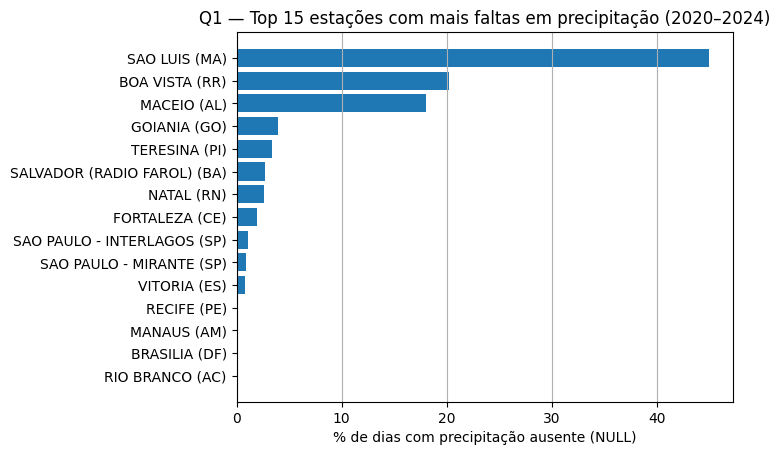

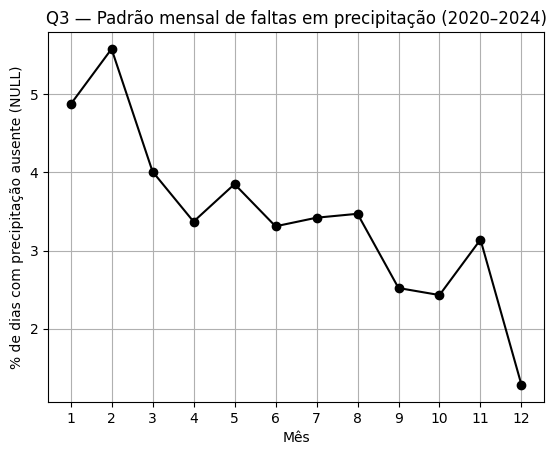

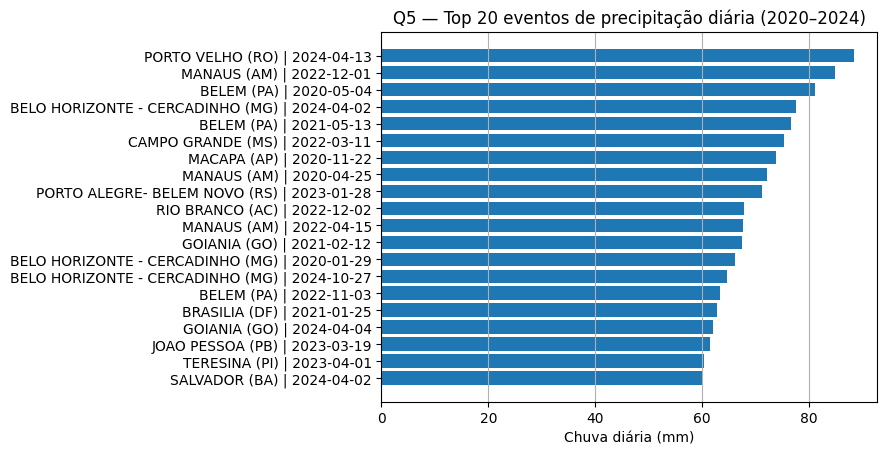

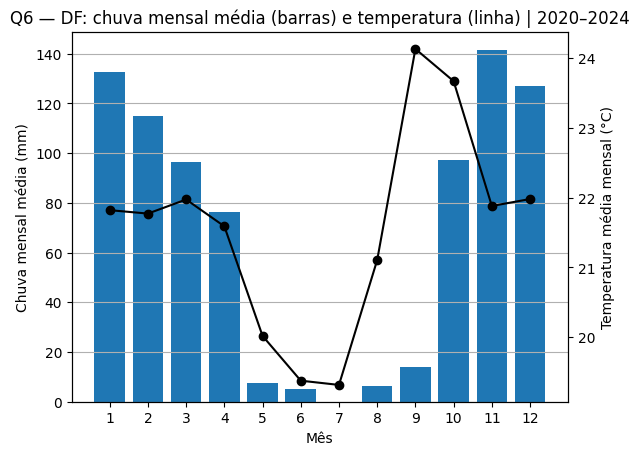

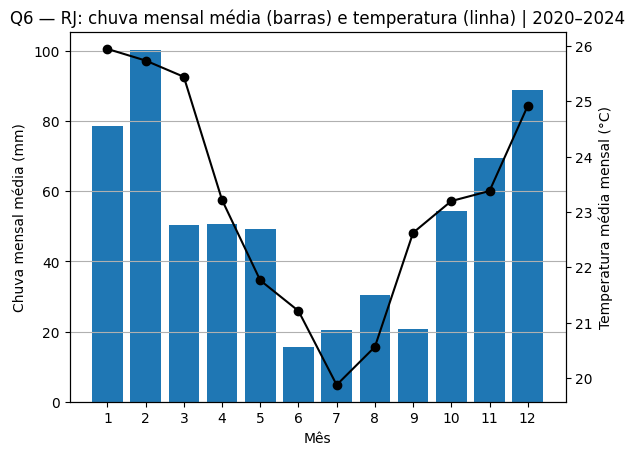

In [0]:
import matplotlib.pyplot as plt

# ---------- Q1: Top 15 faltas em precipitação ----------
df1 = spark.sql("SELECT * FROM q1_faltas_estacao").toPandas()
df1 = df1.sort_values("pct_rain_null", ascending=True)

plt.figure()
plt.barh(df1["local"], df1["pct_rain_null"])
plt.xlabel("% de dias com precipitação ausente (NULL)")
plt.title("Q1 — Top 15 estações com mais faltas em precipitação (2020–2024)")
plt.grid(True, axis="x")
plt.show()

# ---------- Q3: sazonalidade de faltas ----------
df3 = spark.sql("SELECT * FROM q3_sazonal_null_mes").toPandas()

plt.figure()
plt.plot(df3["month"], df3["pct_rain_null"], marker="o", color="black")
plt.xticks(range(1, 13))
plt.xlabel("Mês")
plt.ylabel("% de dias com precipitação ausente (NULL)")
plt.title("Q3 — Padrão mensal de faltas em precipitação (2020–2024)")
plt.grid(True)
plt.show()

# ---------- Q5: Top eventos (barra) ----------
df5 = spark.sql("SELECT * FROM q5_top_eventos").toPandas()
df5 = df5.sort_values("chuva_dia_mm", ascending=True)

labels = (df5["local"] + " | " + df5["date"].astype(str)).tolist()

plt.figure()
plt.barh(labels, df5["chuva_dia_mm"])
plt.xlabel("Chuva diária (mm)")
plt.title("Q5 — Top 20 eventos de precipitação diária (2020–2024)")
plt.grid(True, axis="x")
plt.show()

# ---------- Q6: DF e RJ (chuva barras + temp linha) ----------
df6 = spark.sql("SELECT * FROM q6_clima_df_rj").toPandas()

def plot_combo(uf: str):
    sub = df6[df6["state"] == uf].sort_values("month")
    meses = sub["month"].tolist()

    fig, ax1 = plt.subplots()
    ax1.bar(meses, sub["chuva_media_mensal_mm"])
    ax1.set_xlabel("Mês")
    ax1.set_ylabel("Chuva mensal média (mm)")
    ax1.set_xticks(range(1, 13))
    ax1.grid(True, axis="y")

    ax2 = ax1.twinx()
    ax2.plot(meses, sub["temp_media_mensal_c"], color="black", marker="o")
    ax2.set_ylabel("Temperatura média mensal (°C)")

    ax1.set_title(f"Q6 — {uf}: chuva mensal média (barras) e temperatura (linha) | 2020–2024")
    plt.show()

plot_combo("DF")
plot_combo("RJ")


In [0]:
from pyspark.sql import functions as F

# ============================================================
# Q2) Variáveis mais associadas a falha de precipitação
# (condicionado a rain_max IS NULL)
# ============================================================
q2 = """
SELECT
  SUM(CASE WHEN rain_max IS NULL THEN 1 ELSE 0 END) AS n_dias_rain_null,
  ROUND(100.0 * AVG(CASE WHEN rain_max IS NULL AND rad_max  IS NULL THEN 1 ELSE 0 END), 2) AS pct_rad,
  ROUND(100.0 * AVG(CASE WHEN rain_max IS NULL AND temp_avg IS NULL THEN 1 ELSE 0 END), 2) AS pct_temp,
  ROUND(100.0 * AVG(CASE WHEN rain_max IS NULL AND hum_max  IS NULL THEN 1 ELSE 0 END), 2) AS pct_hum,
  ROUND(100.0 * AVG(CASE WHEN rain_max IS NULL AND wind_avg IS NULL THEN 1 ELSE 0 END), 2) AS pct_wind
FROM mvp.gold.observacoes_gold
"""
row = spark.sql(q2).collect()[0]

assoc = [
    ("rad_max", float(row["pct_rad"])),
    ("temp_avg", float(row["pct_temp"])),
    ("hum_max", float(row["pct_hum"])),
    ("wind_avg", float(row["pct_wind"]))
]
assoc_sorted = sorted(assoc, key=lambda x: x[1], reverse=True)

print("Q2 — Variáveis mais associadas a falhas no registro de precipitação (condicionado a rain_max NULL)")
print(f"- Total de dias com precipitação ausente (rain_max NULL): {int(row['n_dias_rain_null'])}")
print("- Entre esses dias, % em que cada variável também está ausente:")
for var, pct in assoc_sorted:
    print(f"  • {var}: {pct:.2f}%")



# ============================================================
# Q4) Outliers automáticos por IQR (por estação)
# Resposta em texto + ranking de estações
# ============================================================
df = spark.table("mvp.gold.observacoes_gold")

stats = (df
    .where(F.col("rain_max").isNotNull())
    .groupBy("id_station")
    .agg(
        F.expr("percentile_approx(rain_max, 0.25)").alias("q1"),
        F.expr("percentile_approx(rain_max, 0.75)").alias("q3")
    )
    .withColumn("lim_sup", F.col("q3") + 1.5 * (F.col("q3") - F.col("q1")))
)

outliers = (df
    .where(F.col("rain_max").isNotNull())
    .join(stats.select("id_station", "lim_sup"), on="id_station", how="inner")
    .where(F.col("rain_max") > F.col("lim_sup"))
)

n_out = outliers.count()

print("\nQ4 — Identificação automática de outliers de precipitação (IQR por estação)")
print(f"- Total de outliers detectados: {n_out}")

if n_out > 0:
    # top estações com mais outliers
    top_st = (outliers
        .groupBy("city_station", "state", "id_station")
        .count()
        .orderBy(F.col("count").desc())
        .limit(5)
        .toPandas()
    )

    # maior outlier absoluto
    max_out = (outliers
        .select("date", "city_station", "state", "id_station", "rain_max", "lim_sup")
        .orderBy(F.col("rain_max").desc())
        .limit(1)
        .toPandas()
        .iloc[0]
    )

    print("- Top 5 estações com mais outliers (IQR):")
    for _, r in top_st.iterrows():
        print(f"  • {r['city_station']} ({r['state']}) [{r['id_station']}]: {int(r['count'])} outliers")

    print("\n- Maior outlier identificado:")
    print(f"  • {max_out['city_station']} ({max_out['state']}) em {max_out['date']} — {max_out['rain_max']:.1f} mm (limiar IQR={max_out['lim_sup']:.1f} mm)")

else:
    print("👉 Nenhum outlier foi identificado pelo critério de IQR com os dados disponíveis.")


Q2 — Variáveis mais associadas a falhas no registro de precipitação (condicionado a rain_max NULL)
- Total de dias com precipitação ausente (rain_max NULL): 1634
- Entre esses dias, % em que cada variável também está ausente:
  • hum_max: 0.95%
  • rad_max: 0.57%
  • wind_avg: 0.21%
  • temp_avg: 0.00%

Q4 — Identificação automática de outliers de precipitação (IQR por estação)
- Total de outliers detectados: 7455
- Top 5 estações com mais outliers (IQR):
  • CUIABA (MT) [A901]: 412 outliers
  • CAMPO GRANDE (MS) [A702]: 394 outliers
  • BELO HORIZONTE - CERCADINHO (MG) [F501]: 346 outliers
  • BRASILIA (DF) [A001]: 344 outliers
  • GOIANIA (GO) [A002]: 343 outliers

- Maior outlier identificado:
  • PORTO VELHO (RO) em 2024-04-13 — 88.4 mm (limiar IQR=4.5 mm)


## Respostas às perguntas de negócio

1. **Quais estações apresentam mais falhas nos dados de precipitação (dados faltantes) ao longo do tempo?**  
   **R:** São Luís (MA) apresentou a maior taxa de falhas, com cerca de **44%** dos dias com precipitação ausente, seguida por **Boa Vista (RR)** com aproximadamente **20%** e **Maceió (AL)** com cerca de **18%**.

2. **Quais variáveis aparecem mais associadas a falhas no registro de precipitação?**  
   **R:** Considerando apenas os dias em que `rain_max` está ausente (NULL), a variável que mais frequentemente também ficou ausente foi **`hum_max`**, porém com um percentual **baixo (~0,95%)**. Isso sugere que, na maior parte dos casos, a falha em precipitação ocorre de forma relativamente isolada (não acompanhada por ausência simultânea das demais variáveis analisadas).

3. **Há padrões temporais (mensais) nos faltantes de precipitação?**  
   **R:** Observou-se um padrão sazonal nos faltantes: o percentual de dados ausentes tende a ser **maior no início do ano**, especialmente em **janeiro e fevereiro**, reduzindo nos demais meses.

4. **É possível identificar automaticamente outliers de precipitação (IQR por estação)?**  
   **R:** Sim. Foi aplicado o critério de **IQR por estação** (valores acima de `Q3 + 1,5·IQR`). As estações com mais outliers foram: **Cuiabá (MT) (412)**, **Campo Grande (MS) (394)**, **Belo Horizonte – Cercadinho (MG) (346)**, **Brasília (DF) (344)** e **Goiânia (GO) (343)**. O maior outlier identificado ocorreu em **Porto Velho (RO)** em **2024-04-13**, com **88,4 mm**, acima de um limiar IQR de **4,5 mm** para aquela estação.

5. **Quais são os maiores eventos de precipitação diária no período e onde ocorreram?**  
   **R:** Os maiores eventos de precipitação diária do período ocorreram em **Porto Velho (RO)** (até **88,4 mm**) e em **Manaus (AM)** (cerca de **85 mm**), conforme o ranking de maiores valores diários de `rain_max`.

6. **Como é o comportamento sazonal médio (mensal) de precipitação e temperatura para DF e RJ (2020–2024)?**  
   **R:** O comportamento médio mensal é compatível com a climatologia esperada: **verão mais chuvoso e quente** e **inverno mais seco e com temperaturas mais amenas**. No **DF**, o período seco é bem marcado e o período mais quente tende a ocorrer no início da primavera, quando a insolação aumenta em relação ao inverno, mas a precipitação ainda não se estabeleceu de forma regular — favorecendo episódios de calor mais intenso. No **RJ**, a chuva permanece mais distribuída ao longo do ano, com maior concentração nos meses de verão.
